# Privileged Random Forest

**Author:** Elisa Warner  
**Date:** 04/29/2022  
**Description:** An implementation of Privileged Random Forest based on algorithm here:  
https://thebioinformaticsblog.wordpress.com/2022/04/29/privileged-learning-for-random-forest/

Reminder: `iloc[]` overrides index and cares only about index in dataset. `loc[]` looks for rowIndex

In [1]:
# load libraries
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve, auc
from sklearn import tree # for decision tree models
from sklearn.ensemble import RandomForestClassifier # random forest classifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm as tqdm
import pickle as pkl
np.random.seed(120)

Load data

In [2]:
fileDIR = "NewData/"

In [3]:
# Load data
X1 = pd.read_csv(fileDIR + "Clinical_data_for_Elisa_06_07_2022.csv")
keepFeatures = [x for x in list(X1) if "Unnamed" not in x]
X1 = X1[keepFeatures]
X1 = X1[X1['patientId'] == X1['patientId']]

In [4]:
X2 = pd.read_csv(fileDIR + "Biological_baseline_data_for_Elisa.csv")
keepFeatures = [x for x in list(X2) if "Unnamed" not in x]
X2 = X2[keepFeatures]
X2 = X2[list(X2)[:-4]]

In [5]:
X3 = pd.read_csv(fileDIR + "Radiological/Baseline_Lateral_Condyle_Imaging_ Markers_for_Elisa.csv")
keepFeatures = [x for x in list(X3) if "Unnamed" not in x]
X3 = X3[keepFeatures]

In [6]:
keyList = list(X3)
valueList = ["LC_" + x for x in keyList]
X3 = X3.rename(columns = dict(zip(keyList, valueList), inplace = True))

In [7]:
X4 = pd.read_csv(fileDIR + "Radiological/Baseline_Lateral_Fossa_Imaging_Markers_Elisa.csv")
keepFeatures = [x for x in list(X4) if "Unnamed" not in x]
X4 = X4[keepFeatures]

In [8]:
keyList = list(X4)
valueList = ["LF_" + x for x in keyList]
X4 = X4.rename(columns = dict(zip(keyList, valueList), inplace = True))

In [9]:
X5 = pd.read_csv(fileDIR + "Radiological/Joint_space_measurments_baseline_for_Elisa.csv")
keepFeatures = [x for x in list(X5) if "Unnamed" not in x]
X5 = X5[keepFeatures]

In [10]:
ids = []
for ID in X5['patient']:
    name = int(ID[:-1])
    ids.append(name)
X5['patient'] = ids

In [11]:
X = X1.merge(X2, how="left", on="patientId")
X = X.merge(X3, how="left", left_on = "patientId", right_on="LC_Patient")
X = X.merge(X4, how="left", left_on = "patientId", right_on="LF_Patient")
X = X.merge(X5, how="left", left_on = "patientId", right_on="patient")

removeFeats = [x for x in X if ("Back" in x) or ("patient" in x) or ("Patient" in x) or ("Health" in x) or ("health" in x) or ("group" in x) or ("gender_y" in x) or ("age_y" in x) or ("owner" in x) or ("date" in x) or ("type" in x)]
removeFeats = removeFeats + [x for x in list(X) if "FU" in x or "Bone_Degenerative_Changes" in x]

In [12]:
y = X['LC_Health_status']
X = X.drop(columns = removeFeats)

Define the privileged features

In [47]:
len([x for x in privFeatures if "Seru" not in x and "SALIVA" not in x])

43

In [13]:
privFeatures = [x for x in list(X) if ('LC_' in x or 'LF_' in x) or ('Bone_Degenerative_Changes' in x) or ("Seru" in x) or ("SALIVA" in x) or ("3D" in x)]
nonprivFeatures = [x for x in list(X) if x not in privFeatures]
print(len(privFeatures), len(nonprivFeatures))

68 6


Remove missing data

In [14]:
extraTest = X[X['tIMP1SALIVA'] != X['tIMP1SALIVA']]
extraY = y.loc[extraTest.index.values]

In [15]:
X = X[X['tIMP1SALIVA'] == X['tIMP1SALIVA']]
y = y.loc[X.index.values]
print(X.shape)

(97, 74)


# Demographic Data

In [16]:
from scipy.stats import ttest_ind

Run the logistic regression before doing this

In [202]:
sub0 = X[y == 0]
sub1 = X[y == 1]
mean0 = sub0.mean().round(2)
mean1 = sub1.mean().round(2)

importantlist = nonprivFeatures + [x for x in final if x not in nonprivFeatures][:10]
                                   
df = pd.DataFrame([mean0, mean1])
df = df[importantlist]
df = df.T

pvals = []
for col in list(importantlist): # list(sub0)
    pvals.append(np.round(ttest_ind(sub0[col], sub1[col])[1],4))

df.columns = ['Control', 'TMJ OA']
df['P-value'] = pvals
df = df.rename({'gender_x': 'Gender', 'age_x':'Age'})
df[['TMJ OA' ,'Control', 'P-value']]

,TMJ OA,Control,P-value
Gender,1.14,1.15,0.9672
Age,40.20,38.71,0.5730
Headaches,1.59,0.60,0.0000
MuscleSoreness,1.06,0.38,0.0004
VerticalRangeUnassistedWOPain,36.08,44.94,0.0001
RestlessSleep,1.29,0.58,0.0016
LC_clusterProminence,33.06,12.40,0.0029
LC_shortRunHighGreyLevelEmphasis,7.79,6.32,0.0036
3D_JS_SI,2.18,2.57,0.0060
LC_correlation,1.30,1.52,0.0180


In [191]:
print(sub0.shape[0], sub1.shape[0])

48 49


In [197]:
print(sub0[sub0['gender_x'] == 1].shape[0], sub1[sub1['gender_x'] == 1].shape[0])

41 42


# Model

Hyperparameters

In [17]:
depth = 7
numTrees = 100
numFeatures = 0 # default is 0 (automatically set to sqrt of data list)

Random Forest Code

In [18]:
class PrivRandomForest():
    def __init__(self, data, labels, depth, numTrees, privilegedFeatureList, nonprivilegedFeatureList, numFeatures = 0, oob_idx = []):
        self.data = data.copy()
        self.labels = labels.copy()
        self.depth = depth
        self.numTrees = numTrees
        self.privFeatures = privilegedFeatureList.copy()
        self.nonprivFeatures = nonprivilegedFeatureList.copy()
        self.rowSize = data.shape[0]
        if numFeatures == 0:
            self.numFeatures = np.max((self.depth, int(np.sqrt(len(list(data))))))
        else:
            self.numFeatures = numFeatures
        self.forest = [] # step 1
        self.featureList = [] # step 1
        self.forestLinkNodes = {} # step 2
        self.scandentTreeDict = {} # step 3
        self.finalForest = [] # step 5
        self.finalFeatureList = [] # step 5
        self.mostImportantFeatures = []
        
        # create oob set, train set
        if oob_idx == []:
            self.train, self.trainLabels = self.sample(self.data, self.labels, 0.75, [])
            oob_idx = np.array(list(set(self.data.index.values) - set(self.train.index.values)))
        else:
            train_idx = np.array(list(set(self.data.index.values) - set(oob_idx)))
            self.train = self.data.loc[train_idx]
            self.trainLabels = self.labels.loc[train_idx]
            
        self.test = self.data.loc[oob_idx]
        self.testLabels = self.labels.loc[oob_idx]
        
        # Run logReg feature selection
        if len(list(self.data)) > len(list(self.nonprivFeatures)):
            self.keep = self.logReg(self.nonprivFeatures.copy(), self.privFeatures)
            #self.keep = self.logReg(self.privFeatures.copy(), self.nonprivFeatures)
            #self.keep = self.privFeatures + self.nonprivFeatures
            self.train = self.train[self.keep]
            self.test = self.test[self.keep]
        else:
            self.keep = []
        
        #print('Train size:', self.train.shape, '\nTest size:', self.test.shape)
        
    """
    [FUNCTION] sample()
        Input: dataframe of data, series of the labels, percent of dataset to sample, number of features allowed in feature bag
        Returns: [dataFrame] One bootstrapped sample of the data based on the input parameters 
    """
    def sample(self, data, labels, p, privData = [], num_feat_bag = 0):
        rowSize = data.shape[0]
        m = int(rowSize * p)
        balance = False
        
        # prevent from picking none of class type
        while not balance:
            idx = np.random.choice(np.arange(rowSize), m, replace = False)
        
            if num_feat_bag > 0:
                feat_bag = np.random.choice(list(data), np.min((num_feat_bag, len(list(data)))), replace = False)
                dataset1 =  data.iloc[idx][feat_bag]
                labels1 = labels.iloc[idx]
            else:
                dataset1 =  data.iloc[idx]
                labels1 = labels.iloc[idx]
            
            testValues = np.array([x for x in range(rowSize) if x not in idx])
            if (np.sum(labels.iloc[testValues]) != 0) and (np.sum(labels.iloc[testValues]) != len(testValues)):
                balance = True
        
        if len(privData) > 0:
            if num_feat_bag > 0:
                privNumFeatBag = np.min((len(list(privData)), num_feat_bag)) #int(0.3 * len(list(privData))) ####### HYPERPARAMETER ##########################
                feat_bag = np.random.choice(list(privData), privNumFeatBag, replace = False)
                dataset2 = privData.iloc[idx]
            else:
                feat_bag = list(privData)

            for feat in list(feat_bag):
                dataset1[feat] = dataset2[feat].values
        
        return dataset1, labels1

    """
    [FUNCTION] logReg()
    Input: keep [list] a list of features that are kept at a baseline (usually the nonpriv features or blank), colList [list] a list of features which are desired to be assessed
    Returns: keep [list] a list of features that have passed the univariate analysis
    """
    def logReg(self, keep, colList):
        # define train, test
        self.accDict = {}
        
        for col in colList:
            scoreCard = []
            for i in range(self.train.shape[0]):
                patIDX = self.train.index.values[i]
                X_test = self.train.loc[patIDX]
                y_test = self.trainLabels.loc[patIDX]
                X_train, y_train = self.train.drop(patIDX, axis=0), self.trainLabels.drop(patIDX,axis=0)

                # run logReg
                input_x = X_train[col].to_numpy().reshape(1, -1).T
                input_y = y_train
                clf = LogisticRegression(random_state=0).fit(input_x, input_y)
                #score = clf.score(X_test[col].to_numpy().reshape(1,-1).T, y_test) 
                score = int(np.round(clf.predict(X_test[col].reshape(1,-1))))
                scoreCard.append(score)
            #print("%s : %s" % (col, np.mean(scoreCard)), end="")
            #acc = np.sum(scoreCard == self.trainLabels.values)/len(scoreCard)
            fpr, tpr, _ = roc_curve(self.trainLabels.values, scoreCard)
            acc = auc(fpr, tpr)
            self.accDict[col] = acc
            
            if acc > 0.55:
                keep.append(col)
        
        return keep
    
    """
    [FUNCTION] createTree()
        Input: data [DataFrame] the data to be used in the tree, labels[Series] a 1-D dataFrame column of labels, privData [optional dataFrame] the privileged data to be used
          in the tree, must have the same row length as data
        Returns: forest [list] the forest of decision trees, features [list] a list of the features used in each tree -- same length as forest
        Description: Creates the Random "Forest" from multiple decision trees
    """
    def createTree(self, data, labels, privData = []):
        
        forest = []
        features = []
        
        # create forest
        for i in range(numTrees):
            treeData, treeLabels = self.sample(data, labels, 0.7, privData, self.numFeatures) # bootstrap, restrict feature bag ###### 05/26
            features.append(list(treeData))
            

            clf = tree.DecisionTreeClassifier(random_state = 0)
            model = clf.fit(treeData, treeLabels)
            forest.append(model)
        
        return (forest, features)
    
    """
    [FUNCTION] randomForest()
        Input: None
        Returns: None
        Description: runs the Random Forest model
    """
    def randomForest(self):
        # if there are privFeatures then sample separately
        if not self.privFeatures:
            (forest, features) = self.createTree(self.train, self.trainLabels)
        else:
            (forest, features) = self.createTree(self.train[self.nonprivFeatures], self.trainLabels, self.train[self.keep])
        
        self.forest = self.forest + forest
        self.featureList = self.featureList + features
    
    ################################################################################################################
    """
    [FUNCTION] predictFromTree()
        Input: data [dataframe] data to be used for prediction, forest [list of trees], featureList [list] the list of features for each tree in forest.
        Returns: [numpy array] the random forest prediction probability outputs
    """
    # gather the trees togther and average the result
    def predictFromTree(self, data, forest, featureList):
        if data.ndim > 1:
            treeOutput = np.zeros((self.numTrees, data.shape[0]))
        else:
            treeOutput = np.zeros((self.numTrees, 1))
        
        for idx, model in enumerate(forest):
            alter = False
            # check if it's only one data point
            Ndata = data[featureList[idx]]
            if alter:
                print(Ndata)

            if Ndata.ndim == 1:
                alter = True
                Ndata = Ndata.to_numpy().reshape(1,-1)
            
            predicted = model.predict_proba(Ndata)
            treeOutput[idx, :] = treeOutput[idx, :] + predicted[:,1]
            
        if alter:
            return np.sum(treeOutput) / self.numTrees
        
        return np.sum(treeOutput, axis = 0) / self.numTrees
    ######################################################################################################################
    """
    [FUNCTION] runTest()
        Input: testdata[DataFrame], testlabels[Series], forest[list of trees], featureList[list of lists], suppress [bool]
        Returns: [No return] Outputs a figure.
        Description: Outputs the ROC curve for RandomForest predictions. Also creates two variables, self.roc which gives the ROC curve of the results, and self.stderr,
          which gives the stderr of the results.
    """
    def runTest(self, testdata, testlabels, forest, featureList, suppress = False):
        
        #try:
        #    ############################## ADD ON EXTRAS
        #    testdata2 = testdata.append(extraTest[self.nonprivFeatures])
        #    testlabels2 = testlabels.append(extraY)
        
        #    # predict results
        #    predicted = self.predictFromTree(testdata2, forest, featureList)
        #    testdata = testdata2
        #    testlabels = testlabels2
        #    #print("Extra data included", print(testdata.shape, testlabels.shape))
        #except:
        predicted = self.predictFromTree(testdata, forest, featureList)

        if len(testlabels) == 1:
            return float(predicted)
        
        # Code quoted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        fpr, tpr, _ = roc_curve(testlabels, predicted)
        roc_auc = auc(fpr, tpr)
        self.roc = roc_auc
        self.stderr = np.std(np.abs(testlabels - predicted)) / np.sqrt(len(testlabels))
        
        if not suppress:
            plt.figure()
            lw = 2
            plt.plot(
                fpr,
                tpr,
                color="darkorange",
                lw=lw,
                label="ROC curve (area = %0.2f)" % roc_auc,
            )
            plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver operating curve for OOB Test Set")
            plt.legend(loc="lower right")
            plt.show()

    
    """
    [FUNCTION] oobTest()
        Input: suppress [bool] choose to show ROC curve (True) or not (False)
        Returns: None
        Description: Test non-privileged RF with built-in OOB sample
    """
    def oobTest(self, suppress = False):
        if len(self.testLabels) != 1:
            self.runTest(self.test, self.testLabels, self.forest, self.featureList, suppress)
        else:
            x = self.runTest(self.test, self.testLabels, self.forest, self.featureList, suppress)
            return float(x)
    
    """
    [FUNCTION] returnFeatures()
        Input: tr [tree object] a single support tree, nodeIDX [int] index of the node, leftChildList [list] list of all left children, 
          rightChildList [list] list of all right children, featureList [list of lists] list of features used in tree object
        Returns: OutFeatures [list] : returns the node feature of the parent, left child, right child
                [If there is no child which contains a feature (must split to have a feature), then nothing is appended to OutFeatures]
    """
    def returnFeatures(self, tr, nodeIDX, leftChildList, rightChildList, featureList):
        outFeatures = []
    
        ftParentIndex = tr.tree_.feature[nodeIDX]

        # if node is a leaf node
        if ftParentIndex < 0:
            return outFeatures
        
        outFeatures.append(featureList[ftParentIndex]) # parent
    
        children = [leftChildList[nodeIDX], rightChildList[nodeIDX]]
    
        for child in children:
            if child >= 0:
                ftChildIDX = tr.tree_.feature[child] # get the index of the feature
                if ftChildIDX >= 0:
                    outFeatures.append((child, featureList[ftChildIDX], ftChildIDX)) # get the name of the feature
                    
        return outFeatures
    
    """
    [FUNCTION] findLinkNodes()
        Input: tr [tree object], left_child [list] list of left children, right_child [list] list of right children, trIDX [int] the index of the tree object in the forest
        Returns: linkNodeList [list] : returns a list of link nodes as per the criteria in Moradi et al.
    """
    def findLinkNodes(self, tr, left_child, right_child, trIDX):
        linkNodeList = [0]
        n_nodes = tr.tree_.node_count
        
        for node_no in range(n_nodes-1):
            feats = self.returnFeatures(tr, node_no, left_child, right_child, self.featureList[trIDX])
            
            if not feats:
                continue
    
            if len(feats) > 1:
                parFeat = feats[0]
        
            for feat in feats[1:]:            
                if feat[1] in privFeatures and parFeat not in privFeatures:
                    linkNodeList.append(feat[0])
                elif parFeat in privFeatures and feat[1] not in privFeatures:
                    linkNodeList.append(feat[0])

        return linkNodeList
    
    """
    [FUNCTION] printPlot()
        Input: tr [tree object]
        Returns: [No return] Displays a plot of the tree
    """
    def printPlot(self, tr):
        fig, _ = plt.subplots(figsize = (20,10))
        sklearn.tree.plot_tree(tr)
        plt.show()
    
    """
    [FUNCTION] createscandentTree()
        Input: tr [tree object], right_child [list] list of right children, linkNodeList [list] list of link nodes, TreeIDX [int] index of the tree in the forest
        Returns: [list of tree objects] list of scandent trees
        Description: given a tree and the link nodes, creates scandent trees as described in Moradi et al, appends to list of scandent trees
    """
    def createscandentTree(self, tr, right_child, linkNodeList, TreeIDX):
        # This is where we train all of training data to tree
        node_indicator = tr.decision_path(self.train[self.featureList[TreeIDX]]).toarray() # note that we use all of train and not just sample from bag
        # authors say they do this to prevent overfitting
        
        scandentTreeList = []
        for node_i in linkNodeList:
            # node idx
            child1_IDX = right_child[node_i]
            # since pop(child0_samples) + pop(child1_samples) = pop(node_i_samples), then we only need one of the nodes
    
            # dataset idx
            x1_IDX = np.where(node_indicator[:,child1_IDX] == 1)[0] # gives pos index, not rowIndex
            
            # use train set to form labels
            scandentData = self.train.copy()
            scandentData['label'] = 0
            scandentData.iloc[x1_IDX,-1] = 1
            labels = scandentData['label']
            scandentData = scandentData[nonprivFeatures]
            
            # train the scandent tree
            clf = tree.DecisionTreeClassifier(random_state = 1)
            model = clf.fit(scandentData, labels)
            scandentTreeList.append(model)
            
        return scandentTreeList
    
    
    """
    [FUNCTION] createFeatures()
        Input: This takes in the 
        Returns:
    """
    def createFeatures(self, inputData, scandentTrees, linkNodeList, TreeIDX): 
        newTrainData = pd.DataFrame()
        
        # if input is only one
        if inputData.ndim == 1:
            inputData = inputData.to_numpy().reshape(1,-1)
        
        for idx, model in enumerate(scandentTrees):
            featureName = "feat_tree%s_LinkNode%s" % (TreeIDX, linkNodeList[idx])
            predFeatures = model.predict(inputData)
            newTrainData[featureName] = predFeatures
        
        return newTrainData
    
    """
    [FUNCTION] createscandentForest()
        Input: None
        Returns: Iterates through the forest to create scandent trees for each tree
                [Essentially the wrapper function for creating scandent trees]
    """
    def createscandentForest(self, data):
        newDataSet = pd.DataFrame()
        
        featNames = []
        for idx, tree in enumerate(self.forest):
            left_child = tree.tree_.children_left
            right_child = tree.tree_.children_right
            
            self.forestLinkNodes[idx] = self.findLinkNodes(tree, left_child, right_child, idx)
            self.scandentTreeDict[idx] = self.createscandentTree(tree, right_child, self.forestLinkNodes[idx], idx)
            
            newFeatures = self.createFeatures(data, self.scandentTreeDict[idx], self.forestLinkNodes[idx], idx)
            featNames = featNames + list(newFeatures)
            newDataSet = pd.concat([newDataSet, newFeatures], axis=1, ignore_index = True)
        
        newDataSet.columns = featNames
        return newDataSet
    
    """
    [FUNCTION] getscandentFeatures()
        Input: [DataFrame] input dataframe with nonprivileged features
        Returns: [DataFrame] the scandent feature dataFrame only
    """
    def getscandentFeatures(self, data):
        privFeat = pd.DataFrame()
        
        featNames = []
        for idx in range(self.numTrees):
            newFeatures = self.createFeatures(data, self.scandentTreeDict[idx], self.forestLinkNodes[idx], idx)
            featNames = featNames + list(newFeatures)
            privFeat = pd.concat([privFeat, newFeatures], axis = 1, ignore_index = True)
        
        privFeat.columns = list(featNames)
        return privFeat
    
    """
    [FUNCTION] featureSelection
        Input: data [DataFrame] input dataframe with nonprivileged features, inputLabels [Series] col of data which has labels
        Returns: mostImportantFeatures [list] a list of the features ranked from most to least important
    """
    def featureSelection(self, data, inputLabels):
        # feature importance
        clf = RandomForestClassifier(max_depth=self.depth)
        clf.fit(data, inputLabels)
        importance = clf.feature_importances_
        impIDX = np.argsort(importance)[::-1]
        impIDX = np.array([x for x in impIDX if importance[x] > 0])
        mostImportantFeatures = [list(data)[x] for x in impIDX] #[:int(0.5 * len(impIDX))] # top third most important priv Features
        return mostImportantFeatures
        
    """
    [FUNCTION] privRandomForest()
        Input: None
        Returns: None
        Description: This operates the privileged Random Forest model. It creates scandentData by indentifying link nodes and creating scandent trees, then runs as feature
           selection to choose the most promising scandent features, then runs a final random forest.
    """
    def privRandomForest(self):
        # run RF if haven't already
        if not self.forest:
            print("Step 1 Random Forest not completed, running now")
            self.randomForest()
        
        # create scandent forest and features
        self.scandentData = self.createscandentForest(self.train[self.nonprivFeatures])
        
        # feature importance
        self.mostImportantFeaturesPriv = self.featureSelection(self.scandentData, self.trainLabels)
        self.mostImportantFeaturesPriv = self.mostImportantFeaturesPriv[:int(0.4 * len(self.mostImportantFeaturesPriv))]
        self.scandentData = self.scandentData[self.mostImportantFeaturesPriv]
        self.nonprivFinalFeatures = self.featureSelection(self.train[self.nonprivFeatures], self.trainLabels)
        
        # final Forest, important to make this based on nonprivFeatures
        (forest, features) = self.createTree(self.train[self.nonprivFinalFeatures], self.trainLabels, self.scandentData)
        self.finalForest = self.finalForest + forest
        self.finalFeatureList = self.finalFeatureList + features
    
    """
    [FUNCTION] testPriv()
        Input: testdata [dataframe] test data, testlabels [Series] dataFrame column with labels
        Returns: None
    """
    def testPriv(self, testdata, testlabels, suppress = False):

        self.oobTestPrivData = testdata.copy()
        newPrivFeat = self.getscandentFeatures(self.oobTestPrivData) #[self.mostImportantFeatures]
        for feat in list(newPrivFeat):
            self.oobTestPrivData[feat] = newPrivFeat[feat].values
        
        # then need to alter sample function so that it does feature bagging of both sets which preserves indexes chosen but bags feats separately
        predicted = self.predictFromTree(self.oobTestPrivData, self.finalForest, self.finalFeatureList)
        
        if len(testlabels) == 1:
            return float(predicted)
        
        # Code quoted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
        fpr, tpr, _ = roc_curve(testlabels, predicted)
        roc_auc = auc(fpr, tpr)
        self.roc = roc_auc
        self.stderr = np.std(np.abs(testlabels - predicted)) / np.sqrt(len(testlabels))
        
        if not suppress:
            plt.figure()
            lw = 2
            plt.plot(
                fpr,
                tpr,
                color="darkorange",
                lw=lw,
                label="ROC curve (area = %0.2f)" % roc_auc,
            )
            plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver operating curve for OOB Test Set (RF+)")
            plt.legend(loc="lower right")
            plt.show()
    
    """
    [FUNCTION] oobTestPriv()
        Input: suppress [bool] option to show ROC curve plot (True) or not (False)
        Returns: None
        Description: runs out-of-bag test for data, outputs ROC curve and AUC
    """
    def oobTestPriv(self, suppress = False):
        self.testPriv(self.test[self.nonprivFeatures], self.testLabels, suppress)

## Step 1: Form Support Tree

## Step 2: Identify Link Nodes
1. node i is root node  
2. node i has feature which is privileged but but parent feature is non-priveleged  
3. node i has feature which is non-privelged but parent is priveleged

## Step 3: Create scandent Tree
Find who is left and right child, then based on the data in those sets, train another tree.

## Step 4: Create Features
Use new scandent trees to create features

## Step 5: CREATE FINAL MODEL, only includes non-privileged features
Note: there is an importance to doing feature selection because you don't want to overemphasize the tree features

# Evaluate : Leave-one-out CV & OOB

### LOOCV

Privileged Data Only

In [ ]:
# LOOCV
leftOut_priv_only = []

for i in tqdm.tqdm(X.index.values):
    
    ########### MODEL 0: PRIV ONLY
    c = PrivRandomForest(X[privFeatures], y, depth, numTrees, [], privFeatures, numFeatures, [i])                             ##
    
    # LOOCV for feat selection of priv features
    c.keep = c.logReg([], privFeatures)
    c.train = c.train[c.keep]
    c.test = c.test[c.keep]
    
    c.randomForest()
    leftOut_priv_only.append(c.oobTest(suppress = True))
    

RF+, model with privileged features, scandent data

In [34]:
# LOOCV
leftOut_all_privileged = []
leftOut_rf_plus = []
leftOut_tree_based = []

# for feature analysis
t_mostImportantFeatures = {}
t_forest = {}
t_featureList = {}
t_forestLinkNodes = {}

for i in tqdm.tqdm(X.index.values):

    ######### Model 1: Support Tree, includes Privileged Features
    a = PrivRandomForest(X, y, depth, numTrees, privFeatures, nonprivFeatures, numFeatures, [i])                              ##
    a.randomForest()
    
    ### single sample
    leftOut_all_privileged.append(a.oobTest())
    
    ######### Model 2: Run steps 2 through 5 PRIVELEGED MODEL
    a.privRandomForest()                                                                                                             ##
    a.oobTestPriv(suppress = True)
    
    # feature analysis
    t_mostImportantFeatures[i] = a.mostImportantFeaturesPriv # capture the important priv features
    t_forest[i] = a.forest
    t_featureList[i] = a.featureList
    t_forestLinkNodes[i] = a.forestLinkNodes
    
    ######### Model 2b: Tree-Based only
    tree_based_train = a.scandentData[a.mostImportantFeaturesPriv]
    tree_based_test = a.oobTestPrivData[a.mostImportantFeaturesPriv]
    clf = RandomForestClassifier(max_depth = depth).fit(tree_based_train, a.trainLabels)                                             ##
    pred_y = clf.predict(tree_based_test)
    
     ### Model 2: single sample
    leftOut_rf_plus.append(a.testPriv(a.test[nonprivFeatures], a.testLabels, suppress = True))
    
    ### Model 2b: single sample
    leftOut_tree_based.append(float(clf.predict(a.oobTestPrivData[list(tree_based_train)].to_numpy().reshape(1,-1))))


100%|██████████| 97/97 [51:50<00:00, 32.06s/it]


Control

In [35]:
# LOOCV
leftOut_baseline = []

X2 = X[nonprivFeatures]
for i in tqdm.tqdm(X.index.values):

    ######### Model 3: Baseline
    b = PrivRandomForest(X2, y, depth, numTrees, [], nonprivFeatures, numFeatures, [i])                                             ##
    b.randomForest()

    ### single sample
    leftOut_baseline.append(b.runTest(b.test[nonprivFeatures], b.testLabels, b.forest, b.featureList, suppress = True))

100%|██████████| 97/97 [00:55<00:00,  1.74it/s]


### Out-Of-Bag

### Privileged Only

In [36]:
bootstrap_iter = 200

In [37]:
# Out of Bag
oob_all_privileged = []
oob_rf_plus = []
oob_baseline = []
oob_tree_based = []
oob_priv_only = []

# StdErr
stderr_all_privileged = []
stderr_rf_plus = []
stderr_baseline = []
stderr_tree_based = []
stderr_priv_only = []

In [49]:
for i in tqdm.tqdm(range(bootstrap_iter)):
    
    ########### MODEL 0: PRIV ONLY
    c = PrivRandomForest(X[privFeatures], y, depth, numTrees, [], privFeatures, numFeatures)                             ##
    
    # LOOCV for feat selection of priv features
    c.keep = c.logReg([], privFeatures)
    c.train = c.train[c.keep]
    c.test = c.test[c.keep]
    
    try:
        c.randomForest()
        c.oobTest(suppress = True) # See performance of the support tree
        oob_priv_only.append(c.roc)
        stderr_priv_only.append(c.stderr)
    except:
        continue


 34%|███▍      | 69/200 [22:48<45:07, 20.67s/it]  /home/elisawa/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 98%|█████████▊| 195/200 [1:02:47<01:32, 18.44s/it]/home/elisawa/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative sol

In [ ]:
for i in tqdm.tqdm(range(bootstrap_iter)):
    
    ######### Model 1: Support Tree, includes Privileged Features
    a = PrivRandomForest(X, y, depth, numTrees, privFeatures, nonprivFeatures, numFeatures)                              ##
    a.randomForest()
    
    a.oobTest(suppress = True) # See performance of the support tree
    oob_all_privileged.append(a.roc)
    stderr_all_privileged.append(a.stderr)
    
    ######### Model 2: Run steps 2 through 5 PRIVELEGED MODEL
    a.privRandomForest()                                                                                                             ##
    a.oobTestPriv(suppress = True)
    oob_rf_plus.append(a.roc)
    stderr_rf_plus.append(a.stderr)
    
    ######### Model 2b: Tree-Based only
    tree_based_train = a.scandentData[a.mostImportantFeaturesPriv]
    tree_based_test = a.oobTestPrivData[a.mostImportantFeaturesPriv]
    clf = RandomForestClassifier(max_depth = depth).fit(tree_based_train, a.trainLabels)                                             ##
    pred_y = clf.predict(tree_based_test)
    
    # eval
    #testlabels = a.testLabels.append(extraY)
    testlabels = a.testLabels
    fpr, tpr, _ = roc_curve(testlabels, pred_y)
    oob_tree_based.append(auc(fpr, tpr))
    stderr_tree_based.append(np.std(np.abs(testlabels - pred_y)) / np.sqrt(len(a.testLabels)))


 30%|██▉       | 59/200 [26:29<1:01:47, 26.30s/it]/home/elisawa/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 45%|████▌     | 90/200 [40:29<50:12, 27.38s/it]  

In [ ]:
for i in tqdm.tqdm(range(bootstrap_iter)):
  
    ######### Model 3: Baseline
    X2 = X[nonprivFeatures]
    b = PrivRandomForest(X2, y, depth, numTrees, [], nonprivFeatures, numFeatures)                                             ##
    b.randomForest()
    
    b.oobTest(suppress = True)
    oob_baseline.append(b.roc)
    stderr_baseline.append(b.stderr)


### All at Once

## Results

In [16]:
with open("saved_data_a2.pkl", "rb") as f:
    leftOut_priv_only = pkl.load(f)

In [17]:
with open("saved_data_b.pkl", "rb") as f:
    (leftOut_all_privileged, leftOut_rf_plus, leftOut_tree_based, t_mostImportantFeatures, t_forest, t_featureList, t_forestLinkNodes) = pkl.load(f)

C:\Users\elisa\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [18]:
with open("saved_data_c.pkl", "rb") as f:
    leftOut_baseline = pkl.load(f)

In [19]:
with open("saved_data_d2.pkl", "rb") as f:
    oob_all_privileged, oob_rf_plus, oob_baseline, oob_tree_based, oob_priv_only, stderr_all_privileged, stderr_rf_plus, stderr_baseline, stderr_tree_based, stderr_priv_only, bootstrap_iter = pkl.load(f)

In [20]:
def packageData(y, pred_y, oob, stderr):
    fpr, tpr, _ = roc_curve(y, pred_y)
    roc_auc = auc(fpr, tpr)
    loo_stderr =  np.std(np.abs(y - pred_y)) / np.sqrt(len(y))
    mean_oob = np.mean(oob)
    std_oob = np.std([1-x for x in oob])
    mean_oob_stderr = np.mean(stderr)
    
    return fpr, tpr, {"AUC":roc_auc, "LOO stderr":loo_stderr, "Mean OOB":mean_oob, "std OOB":std_oob, "mean OOB stderr":mean_oob_stderr}

In [21]:
# All privileged
fpr0, tpr0, results0 = packageData(y, leftOut_priv_only, oob_priv_only, stderr_priv_only)
for key in results0:
    results0[key] = np.round(results0[key],4)

In [22]:
# All privie-leged
fpr1, tpr1, results1 = packageData(y, leftOut_all_privileged, oob_all_privileged, stderr_all_privileged)
for key in results1:
    results1[key] = np.round(results1[key],4)

In [23]:
# RF+
fpr2, tpr2, results2 = packageData(y, leftOut_rf_plus, oob_rf_plus, stderr_rf_plus)
for key in results2:
    results2[key] = np.round(results2[key],4)

In [24]:
# Baseline
fpr3, tpr3, results3 = packageData(y, leftOut_baseline, oob_baseline, stderr_baseline)
for key in results3:
    results3[key] = np.round(results3[key],4)

In [25]:
# Tree-Based Only
fpr4, tpr4, results4 = packageData(y, leftOut_tree_based, oob_tree_based, stderr_tree_based)
for key in results4:
    results4[key] = np.round(results4[key],4)

In [26]:
results = {}
# create results dict for DataFrame
for key in results1:
    results[key] = [results0[key], results1[key], results2[key], results3[key], results4[key]]

df = pd.DataFrame(results, index = ["Privileged Only", "Baseline+Privileged", "RF+", "Baseline", "Tree-based Only"])
df

,AUC,LOO stderr,Mean OOB,std OOB,mean OOB stderr
Privileged Only,0.6390,0.0252,0.6163,0.1086,0.0513
Baseline+Privileged,0.7198,0.0267,0.7184,0.0841,0.0530
RF+,0.6798,0.0306,0.6974,0.0888,0.0602
Baseline,0.6518,0.0309,0.6940,0.0883,0.0590
Tree-based Only,0.6692,0.0477,0.6535,0.0813,0.0939


In [27]:
len(oob_tree_based)

400

# Images

**All**

In [28]:
import seaborn as sns
sns.set_theme(color_codes="True")

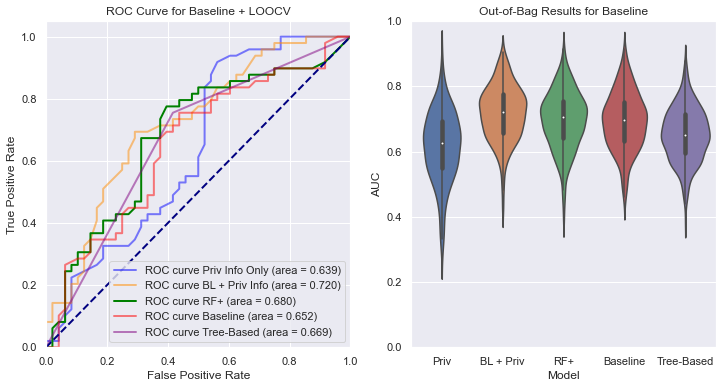

In [30]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

#################### ROC CURVE
lw = 2
ax[0].title.set_text("ROC Curve for Baseline + LOOCV")
ax[0].plot(
    fpr0,
    tpr0,
    color="blue",
    lw=lw,
    alpha=0.5,
    label="ROC curve Priv Info Only (area = %0.3f)" % results0['AUC'],
    )

ax[0].title.set_text("ROC Curve for Baseline + LOOCV")
ax[0].plot(
    fpr1,
    tpr1,
    color="darkorange",
    lw=lw,
    alpha=0.5,
    label="ROC curve BL + Priv Info (area = %0.3f)" % results1['AUC'],
    )

ax[0].plot(
    fpr2,
    tpr2,
    color="green",
    lw=lw,
    label="ROC curve RF+ (area = %0.3f)" %  results2['AUC'],
    )

ax[0].plot(
    fpr3,
    tpr3,
    color="red",
    lw=lw,
    alpha=0.5,
    label="ROC curve Baseline (area = %0.3f)" %  results3['AUC'],
    )

ax[0].plot(
    fpr4,
    tpr4,
    color="purple",
    lw=lw,
    alpha=0.5,
    label="ROC curve Tree-Based (area = %0.3f)" %  results4['AUC'],
    )

ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].legend(loc="lower right")

################## VIOLIN PLOT
labelx = ['Priv' for x in oob_priv_only] + ['BL + Priv' for x in oob_all_privileged] + ['RF+' for x in oob_rf_plus] + ['Baseline' for x in oob_baseline] + ['Tree-Based' for x in oob_tree_based]
labely = oob_priv_only + oob_all_privileged + oob_rf_plus + oob_baseline + oob_tree_based
df = pd.DataFrame()
df['Model'] = labelx
df['AUC'] = labely

sns.violinplot(x="Model", y="AUC", data=df)
ax[1].title.set_text("Out-of-Bag Results for Baseline")
ax[1].set_ylim([0, 1.00])

plt.savefig("Random Forest Results")
plt.show()

Individual

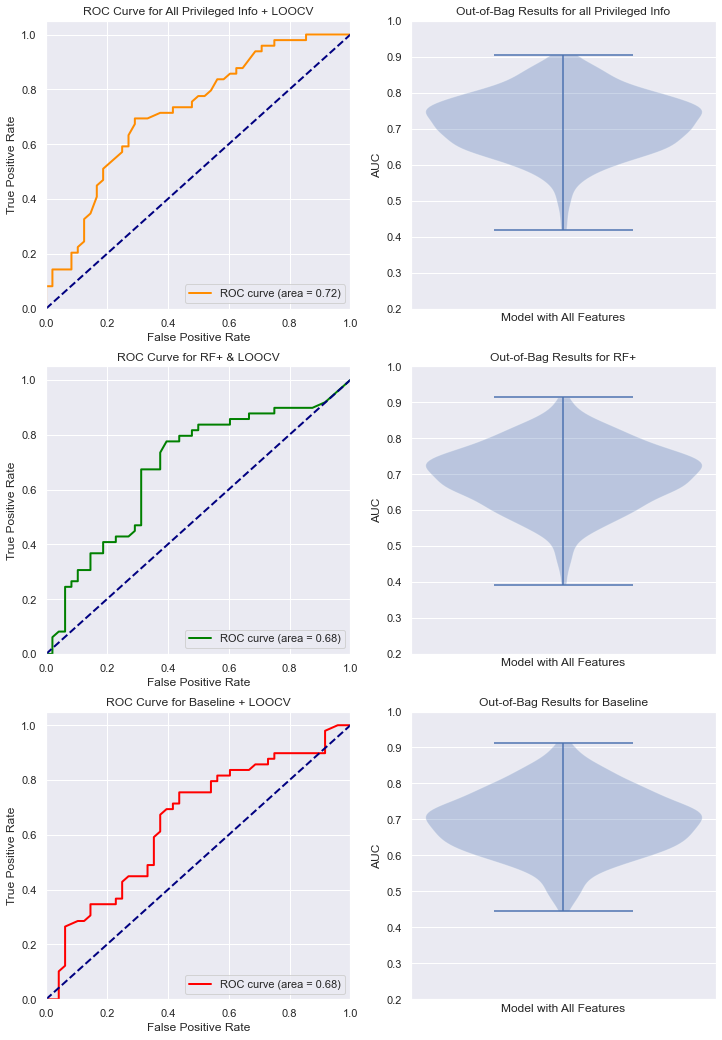

In [31]:
fig, ax = plt.subplots(3,2, figsize = (12,18))

lw = 2

# plot 1
ax[0,0].title.set_text("ROC Curve for All Privileged Info + LOOCV")
ax[0,0].plot(
    fpr1,
    tpr1,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" %  results1['AUC'],
    )
ax[0,0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0,0].set_xlim([0.0, 1.0])
ax[0,0].set_ylim([0.0, 1.05])
ax[0,0].set_xlabel("False Positive Rate")
ax[0,0].set_ylabel("True Positive Rate")
ax[0,0].legend(loc="lower right")
ax[0,1].violinplot(oob_all_privileged)

ax[0,1].title.set_text("Out-of-Bag Results for all Privileged Info")
ax[0,1].set_xticks([])
ax[0,1].set_xlabel("Model with All Features")
ax[0,1].set_ylabel("AUC")
ax[0,1].set_ylim([0.2, 1.00])

# plot 2
ax[1,0].title.set_text("ROC Curve for RF+ & LOOCV")
ax[1,0].plot(
    fpr2,
    tpr2,
    color="green",
    lw=lw,
    label="ROC curve (area = %0.2f)" %  results2['AUC'],
    )
ax[1,0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[1,0].set_xlim([0.0, 1.0])
ax[1,0].set_ylim([0.0, 1.05])
ax[1,0].set_xlabel("False Positive Rate")
ax[1,0].set_ylabel("True Positive Rate")
ax[1,0].legend(loc="lower right")
ax[1,1].violinplot(oob_rf_plus)

ax[1,1].title.set_text("Out-of-Bag Results for RF+")
ax[1,1].set_xticks([])
ax[1,1].set_xlabel("Model with All Features")
ax[1,1].set_ylabel("AUC")
ax[1,1].set_ylim([0.2, 1.00])

# plot 3
ax[2,0].title.set_text("ROC Curve for Baseline + LOOCV")
ax[2,0].plot(
    fpr3,
    tpr3,
    color="red",
    lw=lw,
    label="ROC curve (area = %0.2f)" %  results2['AUC'],
    )
ax[2,0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[2,0].set_xlim([0.0, 1.0])
ax[2,0].set_ylim([0.0, 1.05])
ax[2,0].set_xlabel("False Positive Rate")
ax[2,0].set_ylabel("True Positive Rate")
ax[2,0].legend(loc="lower right")
ax[2,1].violinplot(oob_baseline)

ax[2,1].title.set_text("Out-of-Bag Results for Baseline")
ax[2,1].set_xticks([])
ax[2,1].set_xlabel("Model with All Features")
ax[2,1].set_ylabel("AUC")
ax[2,1].set_ylim([0.2, 1.00])

plt.show()

# Analysis of Tree

In [32]:
import re

In [33]:
from sklearn import tree

In [34]:
featuresUsed = {}
for i in range(len(t_mostImportantFeatures)):
    try:
        nodeList = t_mostImportantFeatures[i]
    except:
        continue
    
    for j in range(len(nodeList)):
        pattern1 = "\d+"
        tree_idx, node = re.findall(pattern1, nodeList[j])
        node_idx = t_forestLinkNodes[i][int(tree_idx)].index(int(node))
        # node_idx only matters if we try to go back to the scandent tree
    
        # a.scandentTreeDict[int(tree)][node]
        featIdx = t_forest[i][int(tree_idx)].tree_.feature[int(node)] # the index of the feature
        feat = t_featureList[i][int(tree_idx)][featIdx]
        print("Tree:", tree_idx, "Node:", node, "Node_IDX:", node_idx, "featNode:", featIdx)
    
        if int(node) == 0:
            feat = feat + '_Root'
        #else:
        #    plt.subplots(figsize=(8,8))
        #    tree.plot_tree(a.forest[int(tree_idx)])
        #    plt.title("Tree %s : %s" % (tree_idx, feat))
        #    plt.show()
        featuresUsed[feat] = featuresUsed.get(feat,0) + 1

Tree: 11 Node: 8 Node_IDX: 4 featNode: 10
Tree: 91 Node: 5 Node_IDX: 2 featNode: 5
Tree: 50 Node: 1 Node_IDX: 1 featNode: 6
Tree: 15 Node: 3 Node_IDX: 4 featNode: 7
Tree: 52 Node: 4 Node_IDX: 4 featNode: 1
Tree: 33 Node: 1 Node_IDX: 1 featNode: 9
Tree: 3 Node: 4 Node_IDX: 3 featNode: 7
Tree: 89 Node: 15 Node_IDX: 6 featNode: 7
Tree: 20 Node: 13 Node_IDX: 4 featNode: 5
Tree: 9 Node: 1 Node_IDX: 1 featNode: 7
Tree: 118 Node: 12 Node_IDX: 5 featNode: 7
Tree: 51 Node: 6 Node_IDX: 4 featNode: 7
Tree: 36 Node: 25 Node_IDX: 9 featNode: 6
Tree: 20 Node: 20 Node_IDX: 6 featNode: 5
Tree: 18 Node: 2 Node_IDX: 2 featNode: 4
Tree: 34 Node: 3 Node_IDX: 3 featNode: 9
Tree: 19 Node: 1 Node_IDX: 1 featNode: 6
Tree: 53 Node: 1 Node_IDX: 1 featNode: 6
Tree: 30 Node: 2 Node_IDX: 3 featNode: 3
Tree: 89 Node: 17 Node_IDX: 7 featNode: 1
Tree: 80 Node: 16 Node_IDX: 2 featNode: 8
Tree: 0 Node: 3 Node_IDX: 5 featNode: 3
Tree: 115 Node: 4 Node_IDX: 3 featNode: 2
Tree: 25 Node: 12 Node_IDX: 4 featNode: 5
Tree: 67

In [35]:
sortedKeys = sorted(featuresUsed, key=lambda x: featuresUsed[x], reverse=True)
for x in sortedKeys[:20]:
    print(x, featuresUsed[x])

VerticalRangeUnassistedWOPain 2748
age_x 2617
LC_shortRunHighGreyLevelEmphasis 1949
 3D_JS_SI 1907
LC_correlation 1884
LC_highGreyLevelRunEmphasis 1618
LC_clusterProminence 1536
LC_BSBV 1230
LC_entropy 1001
LC_runLengthNonuniformity 888
Headaches_Root 870
RestlessSleep 733
Headaches 609
MuscleSoreness 513
VerticalRangeUnassistedWOPain_Root 333
gender_x 198
LC_clusterProminence_Root 140
eNA78SALIVA 102
vEGFSeru 98
LC_shortRunHighGreyLevelEmphasis_Root 91


In [36]:
#### create bar chart for feature importance
tot = 0
for x in sortedKeys:
    tot += featuresUsed[x]
for x in sortedKeys:
    featuresUsed[x] = featuresUsed[x] / tot

In [37]:
featuresUsed['Age'] = featuresUsed['age_x']
featuresUsed['Gender'] = featuresUsed['gender_x']
featuresUsed.pop('age_x')
featuresUsed.pop('gender_x')

0.00918750870029233

In [38]:
sortedKeys = sorted(featuresUsed, key=lambda x: featuresUsed[x], reverse=True)

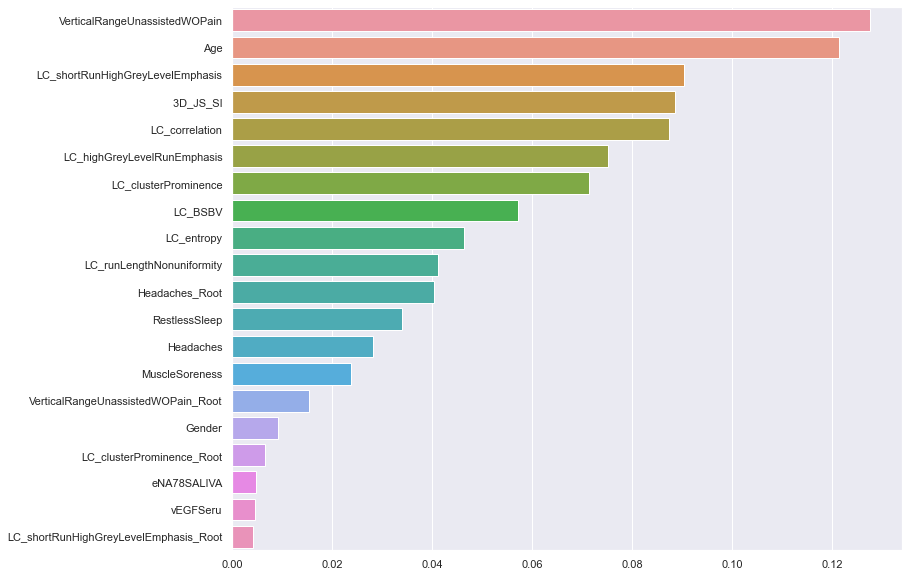

In [43]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(y = sortedKeys[:20], x = [featuresUsed[x] for x in sortedKeys[:20]])
plt.savefig("Importance.png", bbox_inches='tight')

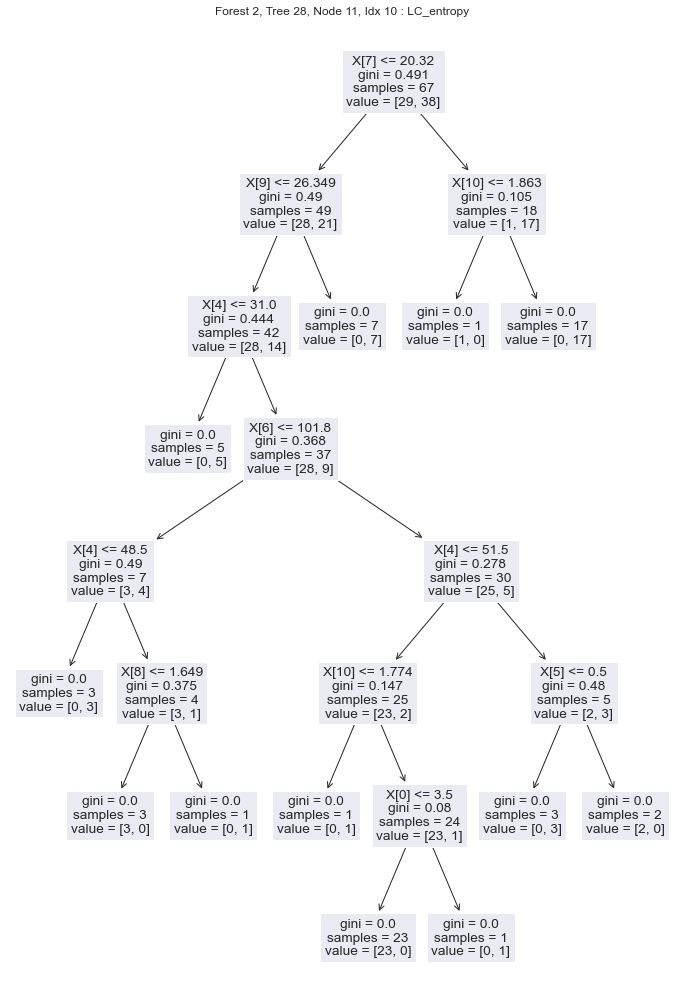

In [42]:
i = 2 # forest index
j = 9 # jth tree

plt.subplots(figsize=(12,18))

# get nodes for ith forest
nodeList = t_mostImportantFeatures[i]

pattern1 = "\d+"
tree_idx, node = re.findall(pattern1, nodeList[j]) # get name for jth linkNodes (name includes tree and node info)

# plot tree_idx-th tree of ith forest
tree.plot_tree(t_forest[i][int(tree_idx)])

# get index of the feature
featIdx = t_forest[i][int(tree_idx)].tree_.feature[int(node)]
feat = t_featureList[i][int(tree_idx)][featIdx]

plt.title("Forest %s, Tree %s, Node %s, Idx %s : %s" % (i, tree_idx, node, featIdx, feat))
plt.savefig("Example2ndforest9thtree.png")
plt.show()

## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr

In [20]:
keepDict = {} #nonprivFeatures
keep = []

for i in tqdm.tqdm(X.index.values):
    leftOut = X.loc[i]
    leftOutLabel = y.loc[i]
    
    X_train = X.drop(i, axis = 0)
    y_train = y.drop(i, axis = 0)
    
    for col in list(X[privFeatures]):
        input_x = X_train[col].to_numpy().reshape(1, -1).T
        input_y = y_train
        clf = LogisticRegression(random_state=0).fit(input_x, input_y) # LogisticRegression(random_state=0)
        # score = clf.score(X_test[col].to_numpy().reshape(1,-1).T, y_test)
        
        score = clf.predict_proba(np.array(float(leftOut[col])).reshape(1,-1))[0][1]
        #print("%s : %s" % (col, score), end="\n")
        
        if col not in keepDict:
            keepDict[col] = []
            
        keepDict[col].append(score)


100%|██████████| 97/97 [00:21<00:00,  4.46it/s]


### Method 1

In [21]:
usedDict = {}
for key in keepDict:
    usedList = [x for x in range(len(keepDict[key])) if keepDict[key][x] > 0.55]
    usedDict[key] = len(usedList)

In [22]:
sortedKeys = sorted(usedDict, key=lambda x: usedDict[x], reverse=True)

In [23]:
for key in sortedKeys[:20]:
    print(key, usedDict[key] / len(X.index.values))

 3D_JS_SI 0.3711340206185567
LC_correlation 0.32989690721649484
LC_entropy 0.30927835051546393
LC_shortRunHighGreyLevelEmphasis 0.30927835051546393
LC_longRunEmphasis 0.29896907216494845
LC_highGreyLevelRunEmphasis 0.29896907216494845
LC_clusterProminence 0.28865979381443296
LC_runLengthNonuniformity 0.28865979381443296
LF_correlation 0.2268041237113402
LC_BSBV 0.21649484536082475
LC_greyLevelNonuniformity 0.20618556701030927
LC_longRunLowGreyLevelEmphasis 0.16494845360824742
LC_TbN 0.15463917525773196
bDNFSeru 0.14432989690721648
oPGSALIVA 0.14432989690721648
tRANCESALIVA 0.13402061855670103
LF_clusterProminence 0.13402061855670103
LF_greyLevelNonuniformity 0.10309278350515463
vECadherinSALIVA 0.07216494845360824
LC_TbTh 0.07216494845360824


### Method 2

In [24]:
for key in keepDict:
    pred = np.array(keepDict[key])
    fpr, tpr, _ = roc_curve(y, pred)
    acc = auc(fpr, tpr)
    keepDict[key] = acc
    print(key, acc)
    
keys = sorted(keepDict, key=lambda x: keepDict[x], reverse=True)

angiogeninSeru 0.21556122448979592
bDNFSeru 0.37414965986394555
cXCL16Seru 0.20918367346938777
eNA78Seru 0.3852040816326531
mMP3Seru 0.027210884353741475
mMP7Seru 0.04804421768707482
oPGSeru 0.036989795918367346
pAI1Seru 0.3890306122448979
tGFb1Seru 0.11692176870748298
tIMP1Seru 0.00042517006802721163
tRANCESeru 0.4409013605442177
vECadherinSeru 0.19727891156462585
vEGFSeru 0.4166666666666667
angiogeninSALIVA 0.19387755102040816
bDNFSALIVA 0.3392857142857142
cXCL16SALIVA 0.20323129251700683
eNA78SALIVA 0.29591836734693877
mMP7SALIVA 0.005102040816326533
oPGSALIVA 0.42389455782312924
pAI1SALIVA 0.0
tGFb1SALIVA 0.04124149659863945
tIMP1SALIVA 0.3801020408163266
tRANCESALIVA 0.37967687074829937
vECadherinSALIVA 0.2393707482993197
vEGFSALIVA 0.27508503401360546
LC_energy 0.3137755102040816
LC_entropy 0.5833333333333334
LC_correlation 0.5999149659863946
LC_inverseDifferenceMoment 0.0
LC_inertia 0.062074829931972796
LC_clusterProminence 0.6377551020408163
LC_shortRunEmphasis 0.13903061224489

In [25]:
final = []
for idx, key in enumerate(keys[:20]):
    print(idx, key, keepDict[key])
    final.append(key)

0 LC_clusterProminence 0.6377551020408163
1 LC_shortRunHighGreyLevelEmphasis 0.6241496598639455
2  3D_JS_SI 0.6147959183673468
3 LC_correlation 0.5999149659863946
4 LC_highGreyLevelRunEmphasis 0.5905612244897959
5 LC_entropy 0.5833333333333334
6 LC_runLengthNonuniformity 0.5484693877551021
7 LC_longRunEmphasis 0.5284863945578231
8 LC_longRunLowGreyLevelEmphasis 0.5263605442176871
9 LC_BSBV 0.5131802721088434
10 LC_greyLevelNonuniformity 0.49319727891156473
11 LC_TbN 0.49192176870748294
12 LC_TbTh 0.47236394557823125
13 LF_correlation 0.4642857142857143
14 LF_greyLevelNonuniformity 0.44345238095238093
15 tRANCESeru 0.4409013605442177
16 oPGSALIVA 0.42389455782312924
17 LF_clusterProminence 0.41921768707483
18 vEGFSeru 0.4166666666666667
19 LC_BVTV 0.41581632653061223


### Summary of Both Methods

In [26]:
df = pd.DataFrame()

for idx, key in enumerate(sortedKeys[:20]):
    finalList = [idx+1, key, (usedDict[key] / len(X.index.values)) * 100, keepDict[key]]
    df = df.append([finalList], ignore_index=True)

df.columns = ['Ranking', 'Feature', 'Percent Folds Used', 'Avg LogReg Val']
df

,Ranking,Feature,Percent Folds Used,Avg LogReg Val
0,1,3D_JS_SI,37.113402,0.614796
1,2,LC_correlation,32.989691,0.599915
2,3,LC_entropy,30.927835,0.583333
3,4,LC_shortRunHighGreyLevelEmphasis,30.927835,0.624150
4,5,LC_longRunEmphasis,29.896907,0.528486
5,6,LC_highGreyLevelRunEmphasis,29.896907,0.590561
6,7,LC_clusterProminence,28.865979,0.637755
7,8,LC_runLengthNonuniformity,28.865979,0.548469
8,9,LF_correlation,22.680412,0.464286
9,10,LC_BSBV,21.649485,0.513180


## Correlation Matrix

In [58]:
datasetCols = privFeatures + nonprivFeatures
datasetCols = datasetCols[::-1]

colArray = np.zeros((len(datasetCols), len(datasetCols)))
sigArray = np.zeros((len(datasetCols), len(datasetCols)))

for idx1, col1  in enumerate(datasetCols):
    for idx2, col2 in enumerate(datasetCols):
            a, b = pearsonr(X[col1], X[col2])
            colArray[idx2][idx1] += a
            sigArray[idx2][idx1] += b

In [75]:
np.sum(np.abs(colArray[0,:]) > 0.2)

9

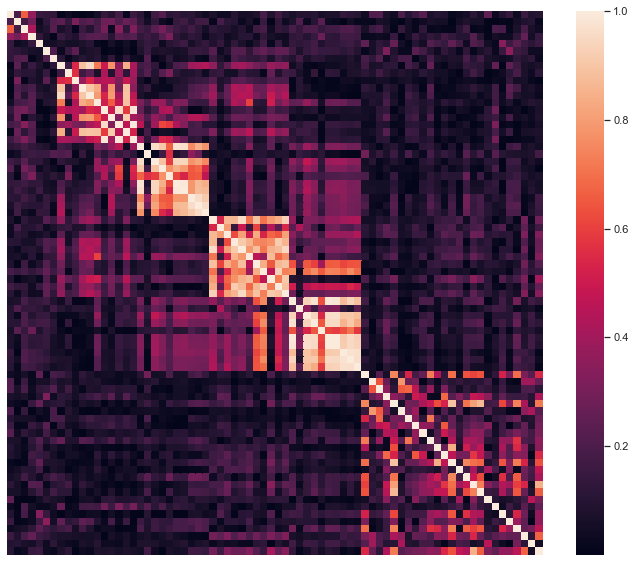

In [59]:
fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(np.abs(colArray))
ax.set_axis_off()
plt.savefig("Corr_Array.png")
plt.show()

In [306]:
privFeatureIdx = [x for x in range(len(datasetCols)) if datasetCols[x] in privFeatures]
nonprivFeatureIdx = [x for x in range(len(datasetCols)) if datasetCols[x] in nonprivFeatures]
sigDict = {}

for idx1 in privFeatureIdx:
    sigDict[datasetCols[idx1]] = []
    for idx2 in nonprivFeatureIdx:
        if np.abs(colArray[idx1][idx2]) > 0.25:
            sigDict[datasetCols[idx1]].append(datasetCols[idx2])

In [307]:
keep = []

for feat in sigDict:
    for x in sigDict[feat]:
        if x not in keep:
            keep.append(x)

In [309]:
len(keep)

16

Interpretation: It appears that these "Af" features seem to correlate heavily with each other and the "C" features correlated heavily with each other, but "Af" and "C" features do not correlate heavily with each other